Importing dependencies

In [24]:
import torch
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn

from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import os
import cv2 as cv

from src.dataset import FrameDataset
from src.utils import collate_fn, Averager, SaveBestModel
from src import config
hparams = config.hparams

We use a label encoder for our classes making sure to set 0 for the background

In [2]:
le = LabelEncoder()
le.fit(['abackground', 'bicycle','human', 'motorcycle', 'vehicle'])

LabelEncoder()

In [6]:
training_data = FrameDataset(root = hparams.train_path, label_encoder = le)
# val_data = FrameDataset(root = hparams.val_path, label_encoder=le)

train_dataloader = DataLoader(training_data, batch_size=hparams.batch_size, shuffle=True, collate_fn=collate_fn)
# val_dataloader = DataLoader(val_data, batch_size=hparams.batch_size, shuffle=True, collate_fn=collate_fn)

Sanity checking data-loader

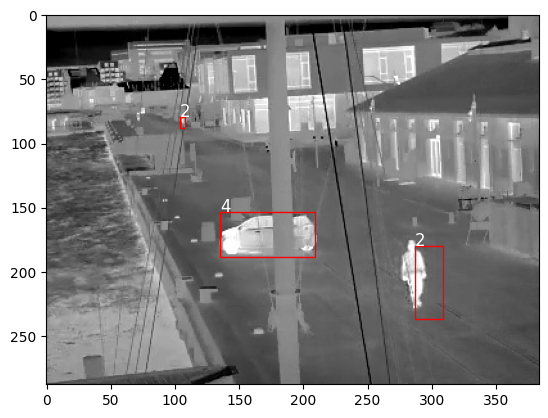

In [51]:
train_features, train_labels = next(iter(train_dataloader))
img = train_features[0].numpy().transpose(1, 2 , 0)
plt.imshow(img)

boxes = train_labels[0]['boxes'].numpy()
labels = train_labels[0]['labels'].numpy()
for box, label in zip(boxes, labels):
    x1, y1, x2, y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    plt.text(x1, y1, label, fontsize = 12, c='white')
    plt.gca().add_patch(Rectangle((x1,y1),(x2-x1),(y2-y1),
                    edgecolor='red',
                    facecolor='none',
                    lw=1))

plt.show()

In [4]:
# load a model; pre-trained on COCO
model = fasterrcnn_resnet50_fpn(num_classes=hparams.num_classes)
device = torch.device(hparams.device)

In [5]:
model.train()
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(model.parameters(), lr=hparams.learning_rate, momentum=0.9, weight_decay=0.00001)


loss_hist = Averager()
itr = 1

for epoch in range(hparams.max_epochs):
    loss_hist.reset()
    
    for frames, targets in train_dataloader:
        
        frames = [frame.to(device) for frame in frames]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(frames, targets)   ##Return the loss

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)  #Average out the loss

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 200 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1

    print(f"Epoch #{epoch} loss: {loss_hist.value}")

Iteration #50 loss: 0.36814434403107865
Iteration #100 loss: 0.3358881357702124
Iteration #150 loss: 0.343179546844417
Iteration #200 loss: 0.5043411239549764
Iteration #250 loss: 0.4155584117938979
Iteration #300 loss: 0.27577452137573527
Iteration #350 loss: 0.24899384515620787
Iteration #400 loss: 0.5403421564894159
Iteration #450 loss: 0.5971994017380827
Iteration #500 loss: 0.30830810682326004
Iteration #550 loss: 0.3175986090868016
Iteration #600 loss: 0.45723234071506036
Iteration #650 loss: 0.675758758796615
Iteration #700 loss: 0.6444362851685171
Iteration #750 loss: 1.007549514312901
Iteration #800 loss: 0.8187508652914958
Iteration #850 loss: 0.17557743551587912
Iteration #900 loss: 0.38316122597116803
Epoch #0 loss: 0.5305003648014625
Iteration #950 loss: 0.4251491779980801
Iteration #1000 loss: 0.6151012527848833
Iteration #1050 loss: 0.1465978109034619
Iteration #1100 loss: 0.5024560375317986
Iteration #1150 loss: 0.563880212736261
Iteration #1200 loss: 0.3076834321546425

In [6]:
# make sure the output directory exists
log_name = log_name = f"{hparams.experiment_name}-{hparams.num_classes}"
output_dir = os.path.join(hparams.output_dir,log_name)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

path = os.path.join(output_dir,  log_name + str(epoch) + '.pth')
torch.save(model, path)

In [ ]:
model = torch.load('products/object_detection-5/object_detection-54.pth')
model.eval()
model.to(torch.device('cpu'))


In [4]:
video_path = 'data/test/clips/20200515/clip_28_1250.mp4'
cap = cv.VideoCapture(video_path)

counter = 0
while(True):
    ret, frame = cap.read()
    if (ret == True) & (counter < 5):
        tens_frame = (frame/255).transpose((2, 0, 1))
        tens_frame = torch.tensor(tens_frame).type(torch.float).unsqueeze(0)
        with torch.no_grad():
            prediction = model(tens_frame)

        boxes = prediction[0]['boxes'].numpy()
        labels = prediction[0]['labels'].numpy()
        scores = prediction[0]['scores'].numpy()
        labels = le.inverse_transform(labels)

        for box, label, score in zip(boxes, labels, scores):
            if score > 0.8:
                x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])

                cv.putText(frame,label,(x1,y1-4),cv.FONT_HERSHEY_SIMPLEX,0.4,(0,255,0),1,cv.LINE_AA)
                cv.rectangle(frame,(x1, y1),(x2, y2),(255,0,0),1)
        
        cv.imshow('video', frame)
        counter +=1
        if cv.waitKey(25) & 0xFF == ord('q'):
            cv.destroyAllWindows()
            break
        
        
 
  # Break the loop
    else: 
        break



: 

(288, 384)
